<a href="https://colab.research.google.com/github/leanring-machine/yt-classifier/blob/main/notebooks/resnet50_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/yt-classifier/data.zip"

In [3]:
!ls -al

total 1860
drwxr-xr-x  1 root root    4096 Jun 11 06:19 .
drwxr-xr-x  1 root root    4096 Jun 11 06:04 ..
drwxr-xr-x  4 root root    4096 Jun  8 18:17 .config
drwx------  5 root root    4096 Jun 11 06:19 drive
drwxr-xr-x  3 root root    4096 Jun 11 06:19 __MACOSX
drwxr-xr-x  1 root root    4096 Jun  8 18:18 sample_data
drwxr-xr-x 17 root root    4096 Jun 10 16:34 thumbnail
-rw-r--r--  1 root root     237 Jun  2 16:25 video_category.csv
-rw-r--r--  1 root root 1871787 Jun 10 18:00 video_info.csv


In [4]:
!pip install ResNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ResNet: filename=resnet-0.1-py3-none-any.whl size=10027 sha256=6c7102910a1134174cd4a788fc0898d433a1e3299f4d89a3e357d92f46026958
  Stored in directory: /root/.cache/pip/wheels/be/62/ef/ac6244da70f4650a13902e0294d88e71cf950b4fb8dbeccb98
Successfully built ResNet


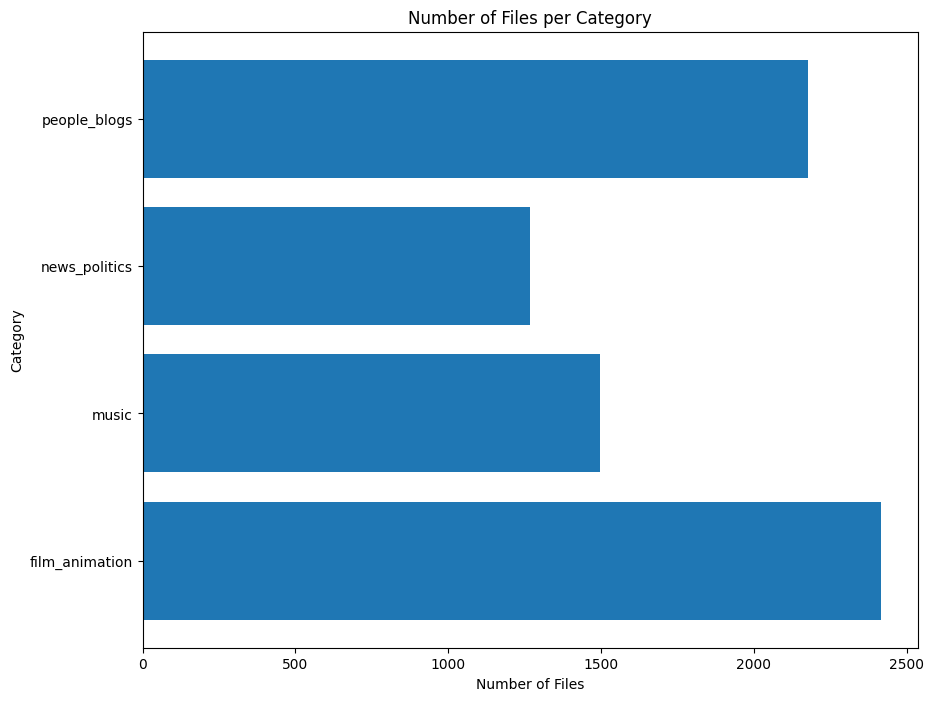

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

category_df = pd.read_csv('video_category.csv')
category_info = category_df.set_index('name')['id'].to_dict()
data_path = './thumbnail'

category_counts = {}

selected_category = [
    'film_animation', 'music', 'news_politics', 'people_blogs'
]

category_counts = {}

for c in selected_category:
  dir = os.path.join(data_path, c)
  category_counts[c] = len(os.listdir(dir))

plt.figure(figsize=(10, 8))
plt.barh(list(category_counts.keys()), list(category_counts.values()))
plt.xlabel('Number of Files')
plt.ylabel('Category')
plt.title('Number of Files per Category')
plt.show()

# ResNet

In [6]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# 데이터셋 경로 설정
base_dir = './thumbnail'

# 이미지 사이즈 설정
img_height = 180
img_width = 320

# 데이터셋 생성
data = []
labels = []

for i, class_name in enumerate(selected_category):
    class_dir = os.path.join(base_dir, class_name)
    img_paths = [os.path.join(class_dir, img_name) for img_name in os.listdir(class_dir)]
    labels.extend([i] * len(img_paths))
    data.extend(img_paths)

# 데이터셋 분할
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=1532)

In [7]:
# ResNet 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# 새로운 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(len(selected_category), activation='softmax')(x)

# 전체 모델 정의
model_resnet = Model(inputs=base_model.input, outputs=predictions)

# 기존 레이어 동결
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model_resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


94765736/94765736 [==============================] - 5s 0us/step


In [8]:
# 데이터 제너레이터 정의
def data_generator(images, labels, batch_size):
    num_samples = len(images)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []
        batch_labels = []
        for index in indices:
            img_path = images[index]
            img = load_img(img_path, target_size=(img_height, img_width))
            img_array = img_to_array(img)
            batch_images.append(img_array)
            batch_labels.append(labels[index])
        batch_images = np.array(batch_images)
        batch_labels = to_categorical(batch_labels, num_classes=len(selected_category))
        yield batch_images, batch_labels

# 모델 학습
batch_size = 32
train_generator = data_generator(train_data, train_labels, batch_size)
test_generator = data_generator(test_data, test_labels, batch_size)

steps_per_epoch = len(train_data) // batch_size
validation_steps = len(test_data) // batch_size

history = model_resnet.fit(train_generator, epochs=30, steps_per_epoch=steps_per_epoch,
                           validation_data=test_generator, validation_steps=validation_steps)

Epoch 1/30
183/183 [==============================] - 27s 82ms/step - loss: 0.9390 - accuracy: 0.6079 - val_loss: 0.7869 - val_accuracy: 0.6993
Epoch 2/30
183/183 [==============================] - 14s 76ms/step - loss: 0.7441 - accuracy: 0.7071 - val_loss: 0.7679 - val_accuracy: 0.7104
Epoch 3/30
183/183 [==============================] - 14s 77ms/step - loss: 0.6755 - accuracy: 0.7382 - val_loss: 0.8089 - val_accuracy: 0.6785
Epoch 4/30
183/183 [==============================] - 14s 75ms/step - loss: 0.6018 - accuracy: 0.7659 - val_loss: 0.8193 - val_accuracy: 0.6806
Epoch 5/30
183/183 [==============================] - 14s 75ms/step - loss: 0.5456 - accuracy: 0.7912 - val_loss: 0.8036 - val_accuracy: 0.6972
Epoch 6/30
183/183 [==============================] - 14s 77ms/step - loss: 0.5022 - accuracy: 0.8096 - val_loss: 0.8427 - val_accuracy: 0.6826
Epoch 7/30
183/183 [==============================] - 14s 76ms/step - loss: 0.4558 - accuracy: 0.8280 - val_loss: 0.8311 - val_accuracy:

In [9]:
# 모델 평가
test_loss, test_accuracy = model_resnet.evaluate(test_generator, steps=validation_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

45/45 [==============================] - 3s 61ms/step - loss: 1.3529 - accuracy: 0.7167
Test Loss: 1.3528578281402588
Test Accuracy: 0.7166666388511658


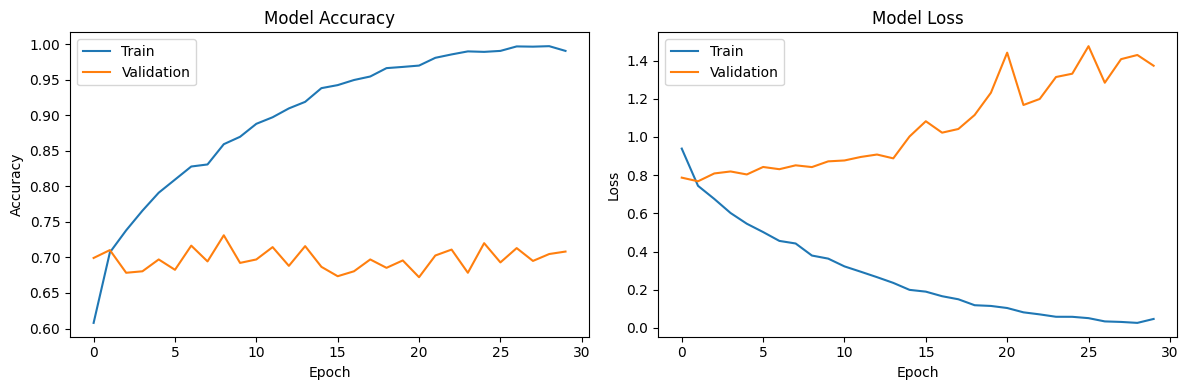

1/1 [==============================] - 1s 965ms/step


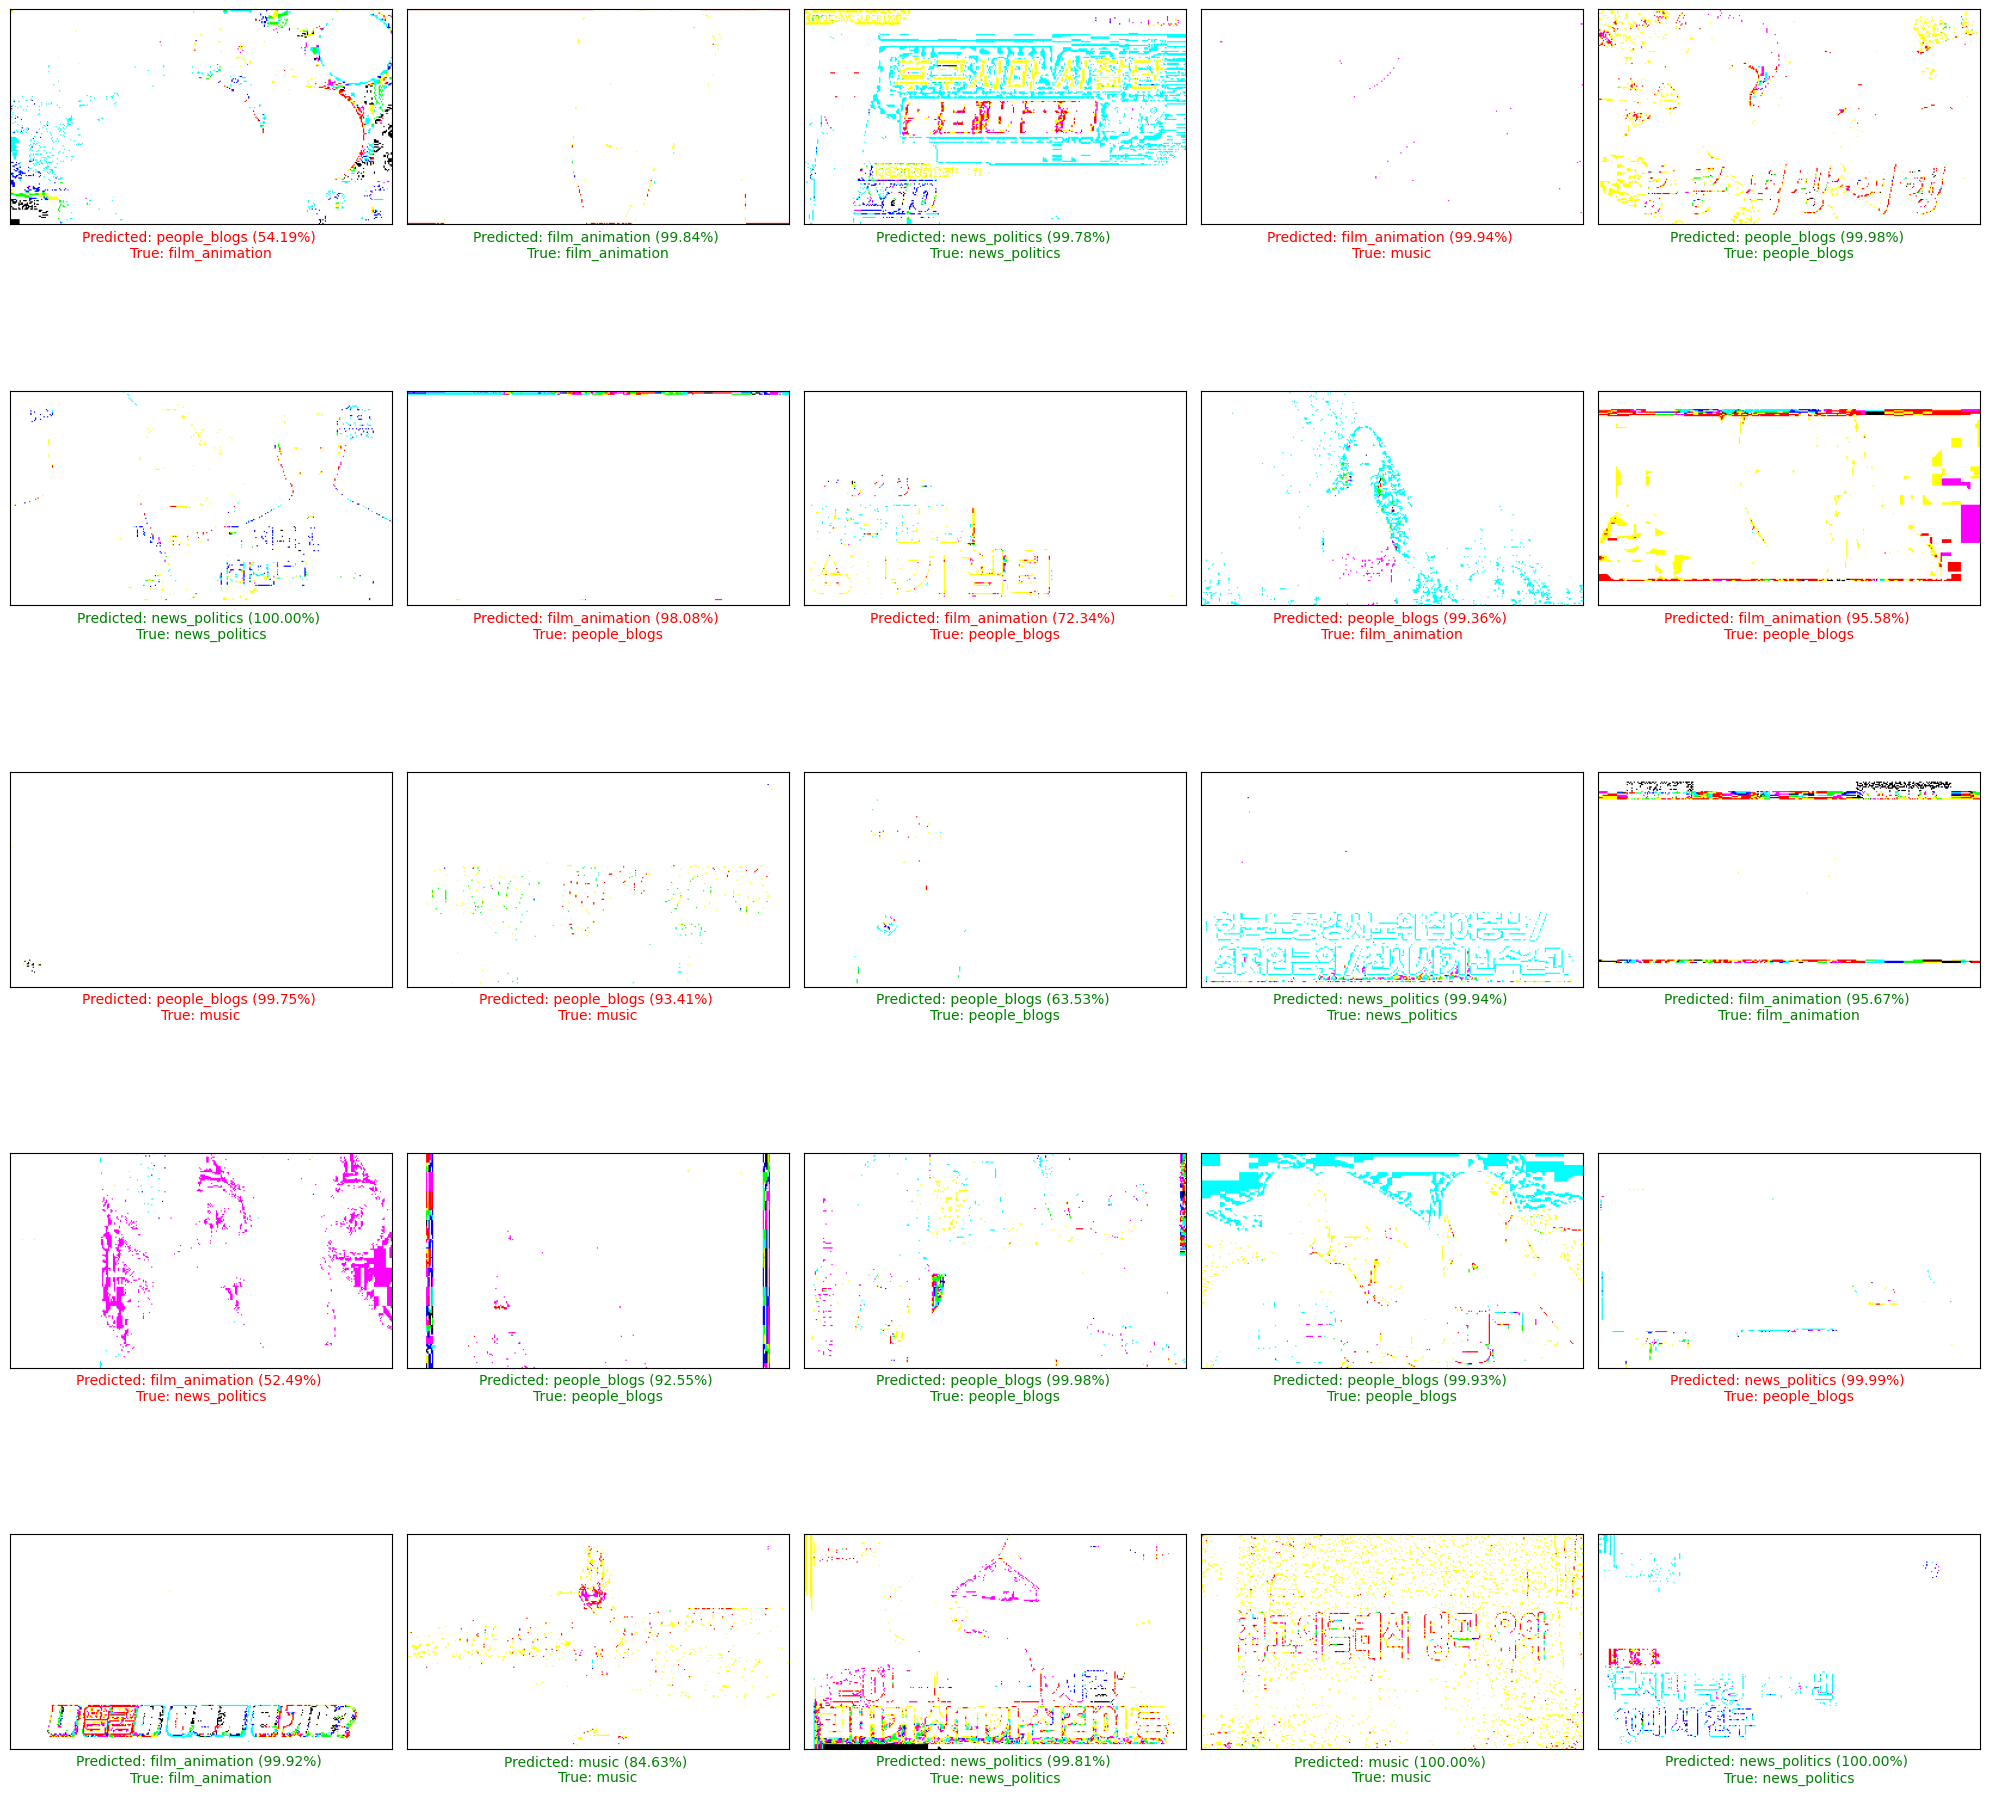

In [10]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
def plot_training_history(history):
    # 정확도 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 손실 함수 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# 학습 과정 시각화
plot_training_history(history)

# 테스트 결과 시각화
def plot_test_results(model, test_generator, num_images=25):
    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)

    plt.figure(figsize=(20, 20))
    for i in range(min(num_images, len(test_images))):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[i], cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions[i])
        true_label = np.argmax(test_labels[i])
        if predicted_label == true_label:
            color = 'green'
        else:
            color = 'red'
        plt.xlabel("Predicted: {} ({:.2f}%) \nTrue: {}".format(
            selected_category[predicted_label], predictions[i][predicted_label] * 100, selected_category[true_label]), color=color)
    plt.tight_layout()
    plt.show()

# 테스트 결과 시각화
plot_test_results(model_resnet, test_generator, num_images=25)


In [11]:
from tensorflow import keras

load_model = keras.models.load_model('drive/MyDrive/resnet_train.keras')

1/1 [==============================] - 0s 26ms/step


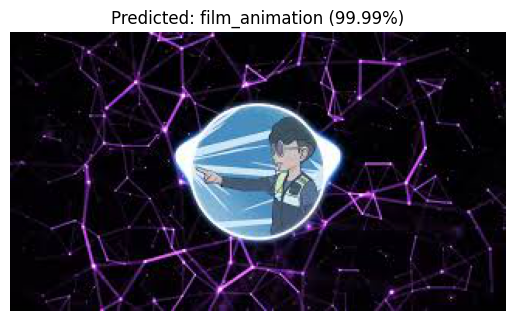

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_height = 180
img_width = 320


# 예측 결과 시각화 및 분석
def predict_image(model, image_path, class_names):
    img_path = image_path
    img = load_img(img_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction)
    confidence = prediction[0][predicted_label] * 100

    plt.imshow(img)
    plt.axis('off')
    plt.title("Predicted: {} ({:.2f}%)".format(class_names[predicted_label], confidence))
    plt.show()

1/1 [==============================] - 0s 28ms/step


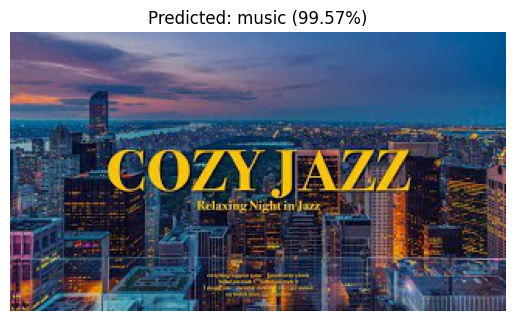

In [15]:
import requests

vid = 'r_E_-FRiyKc'
thumbnail_url = f'https://img.youtube.com/vi/r_E_-FRiyKc/mqdefault.jpg'
response = requests.get(thumbnail_url)
with open(f'{vid}.jpg', 'wb') as f:
  f.write(response.content)
predict_image(model_resnet, f'{vid}.jpg', selected_category)

In [ ]:
model_resnet.save('resnet_train.keras')
!cp resnet_train.keras drive/MyDrive/resnet_train.keras